### Scaling to Large P2CPs

In the [Introduction to P2CPs notebook](https://geomdata.gitlab.io/hiveplotlib/introduction_to_p2cps.html), we used an example of 4 Gaussian blobs in 3-dimensional space to motivate a use case for the Polar Parallel Coordinates Plot (P2CP). 

In this notebook, we contemplate the same example, only with more values in each Gaussian blob. We then demonstrate how to draw the edges with the `hiveplotlib.viz.datashader` backend to show the *density* of edges.

Note: this notebook requires that `hiveplotlib` be installed with the `datashader` package, which can be done by running:

> `pip install hiveplotlib[datashader]`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from hiveplotlib import p2cp_n_axes
from hiveplotlib.datasets import four_gaussian_blobs_3d
from hiveplotlib.viz import axes_viz, p2cp_viz
from hiveplotlib.viz.datashader import datashade_edges_mpl
from matplotlib.colors import ListedColormap

In [2]:
# color palette for the blobs
COLORS = ["#0173b2", "#de8f05", "#029e73", "#cc78bc"]

In the [Introduction to P2CPs notebook](https://geomdata.gitlab.io/hiveplotlib/introduction_to_p2cps.html), we plotted 4 Gaussian blobs with a total of 50 points in each blob.

In [3]:
df = four_gaussian_blobs_3d()

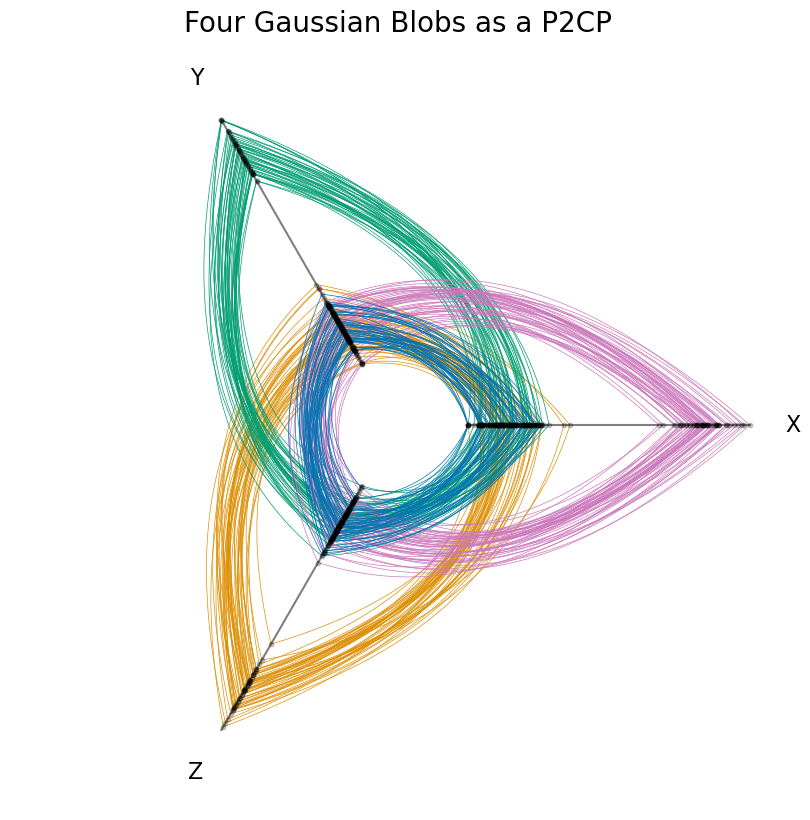

In [4]:
# align the colors with the figure from the paper
indices_dict = [{"color": color} for color in COLORS]

p2cp = p2cp_n_axes(
    data=df,
    split_on="Label",
    vmins=[-1] * 3,
    vmaxes=[6] * 3,
    all_edge_kwargs={"alpha": 1, "lw": 0.5},
    indices_list_kwargs=indices_dict,
)

# the (0, 0, 0) blob gets plotted first by default
#  ends up being obscured by other edges unless
#  we bring its lines to the front by changing zorder
p2cp.add_edge_kwargs(tag=0.0, zorder=3)

fig, ax = p2cp_viz(p2cp, node_kwargs={"s": 10, "alpha": 0.2})
ax.set_title("Four Gaussian Blobs as a P2CP", size=20)
plt.show()

With this number of loops drawn, we don't have any particularly serious concerns about [oversaturation](https://datashader.org/user_guide/Plotting_Pitfalls.html#oversaturation). As we scale up the number of points, however, our overlapping lines blend together to obstruct each other, which risks us making disingenuous inferences from any exploratory visualization.

Below, we scale up from 50 points per blob to 5000 points.

In [5]:
df = four_gaussian_blobs_3d(num_points=5000)

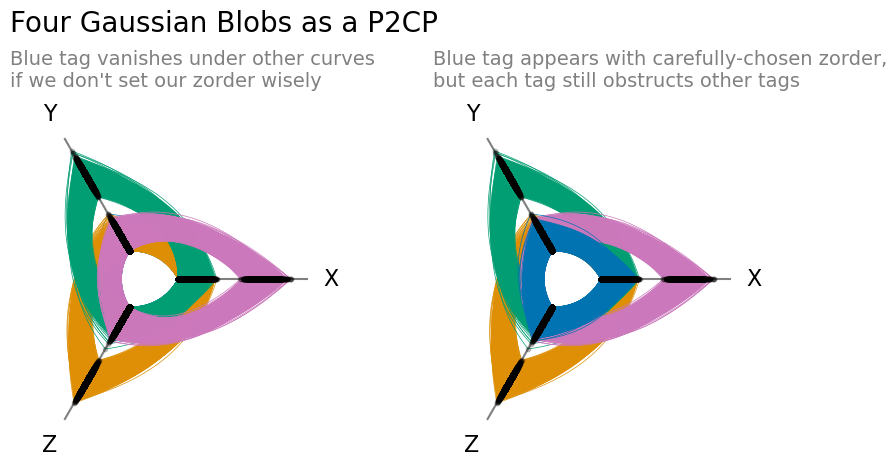

In [6]:
# align the colors with the figure from the paper
indices_dict = [{"color": color} for color in COLORS]

p2cp = p2cp_n_axes(
    data=df,
    split_on="Label",
    vmins=[-1] * 3,
    vmaxes=[8] * 3,
    all_edge_kwargs={"alpha": 1, "lw": 0.5},
    indices_list_kwargs=indices_dict,
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

p2cp_viz(p2cp, node_kwargs={"s": 10, "alpha": 0.2}, fig=fig, ax=axes[0])
axes[0].set_title(
    "Blue tag vanishes under other curves\n" "if we don't set our zorder wisely",
    color="gray",
    loc="left",
    size=14,
    y=1.1,
)


# the (0, 0, 0) blob gets plotted first by default
#  ends up being obscured by other edges unless
#  we bring its lines to the front by changing zorder
p2cp.add_edge_kwargs(tag=0.0, zorder=3)

p2cp_viz(p2cp, node_kwargs={"s": 10, "alpha": 0.2}, fig=fig, ax=axes[1])
axes[1].set_title(
    "Blue tag appears with carefully-chosen zorder,\n"
    "but each tag still obstructs other tags",
    color="gray",
    loc="left",
    size=14,
    y=1.1,
)
fig.suptitle("Four Gaussian Blobs as a P2CP", size=20, ha="left", x=0.125, y=1.17)

axes[0].axis("equal")
axes[1].axis("equal")
plt.show()

When plotting multi-tag P2CPs, particularly when we have a decent amount of data, we should always plot *small multiples* to make sure we aren't hiding any patterns in our visualization.

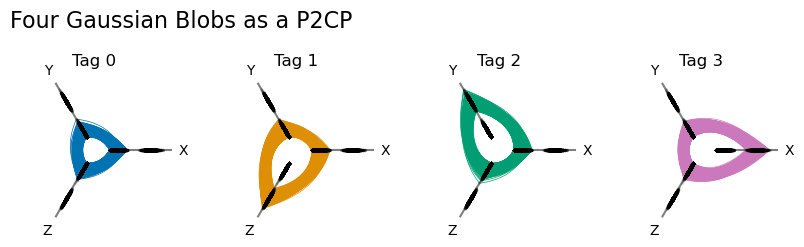

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

for i, tag in enumerate(p2cp.tags):
    p2cp_viz(
        p2cp,
        tags=tag,
        fig=fig,
        ax=axes.flatten()[i],
        axes_labels_fontsize=10,
        node_kwargs={"s": 2, "alpha": 0.1},
    )
    axes.flatten()[i].set_title(f"Tag {tag}")

fig.suptitle("Four Gaussian Blobs as a P2CP", size=16, y=1.2, ha="left", x=0.125)
plt.show()

#### Datashading to Show Edge Density

Discussed in greater detail in the [Hive Plots for Large Networks notebook](https://geomdata.gitlab.io/hiveplotlib/hive_plots_for_large_networks.html), datashading allows us to better visualize the relative density of edges on a figure regardless of the size of our dataset while also taking away the trial and error of playing with `linewidth` and `alpha` values.

To keep our figures consistent with past figures, below we first generate color maps for each tag of data based on their single-color values above. Once we have those color maps, we extend our small multiples visualization by datashading the edges.

In [8]:
cmaps = []
for c in COLORS:
    light = sns.light_palette(c, as_cmap=True)
    dark = sns.dark_palette(c, reverse=True, as_cmap=True)

    temp_cmap = ListedColormap(
        sns.color_palette(light(np.linspace(0.1, 1, int(0.9 / 1.5 * 256))))
        + sns.color_palette(dark(np.linspace(0, 0.6, int(0.6 / 1.5 * 256))))
    )
    cmaps.append(temp_cmap)

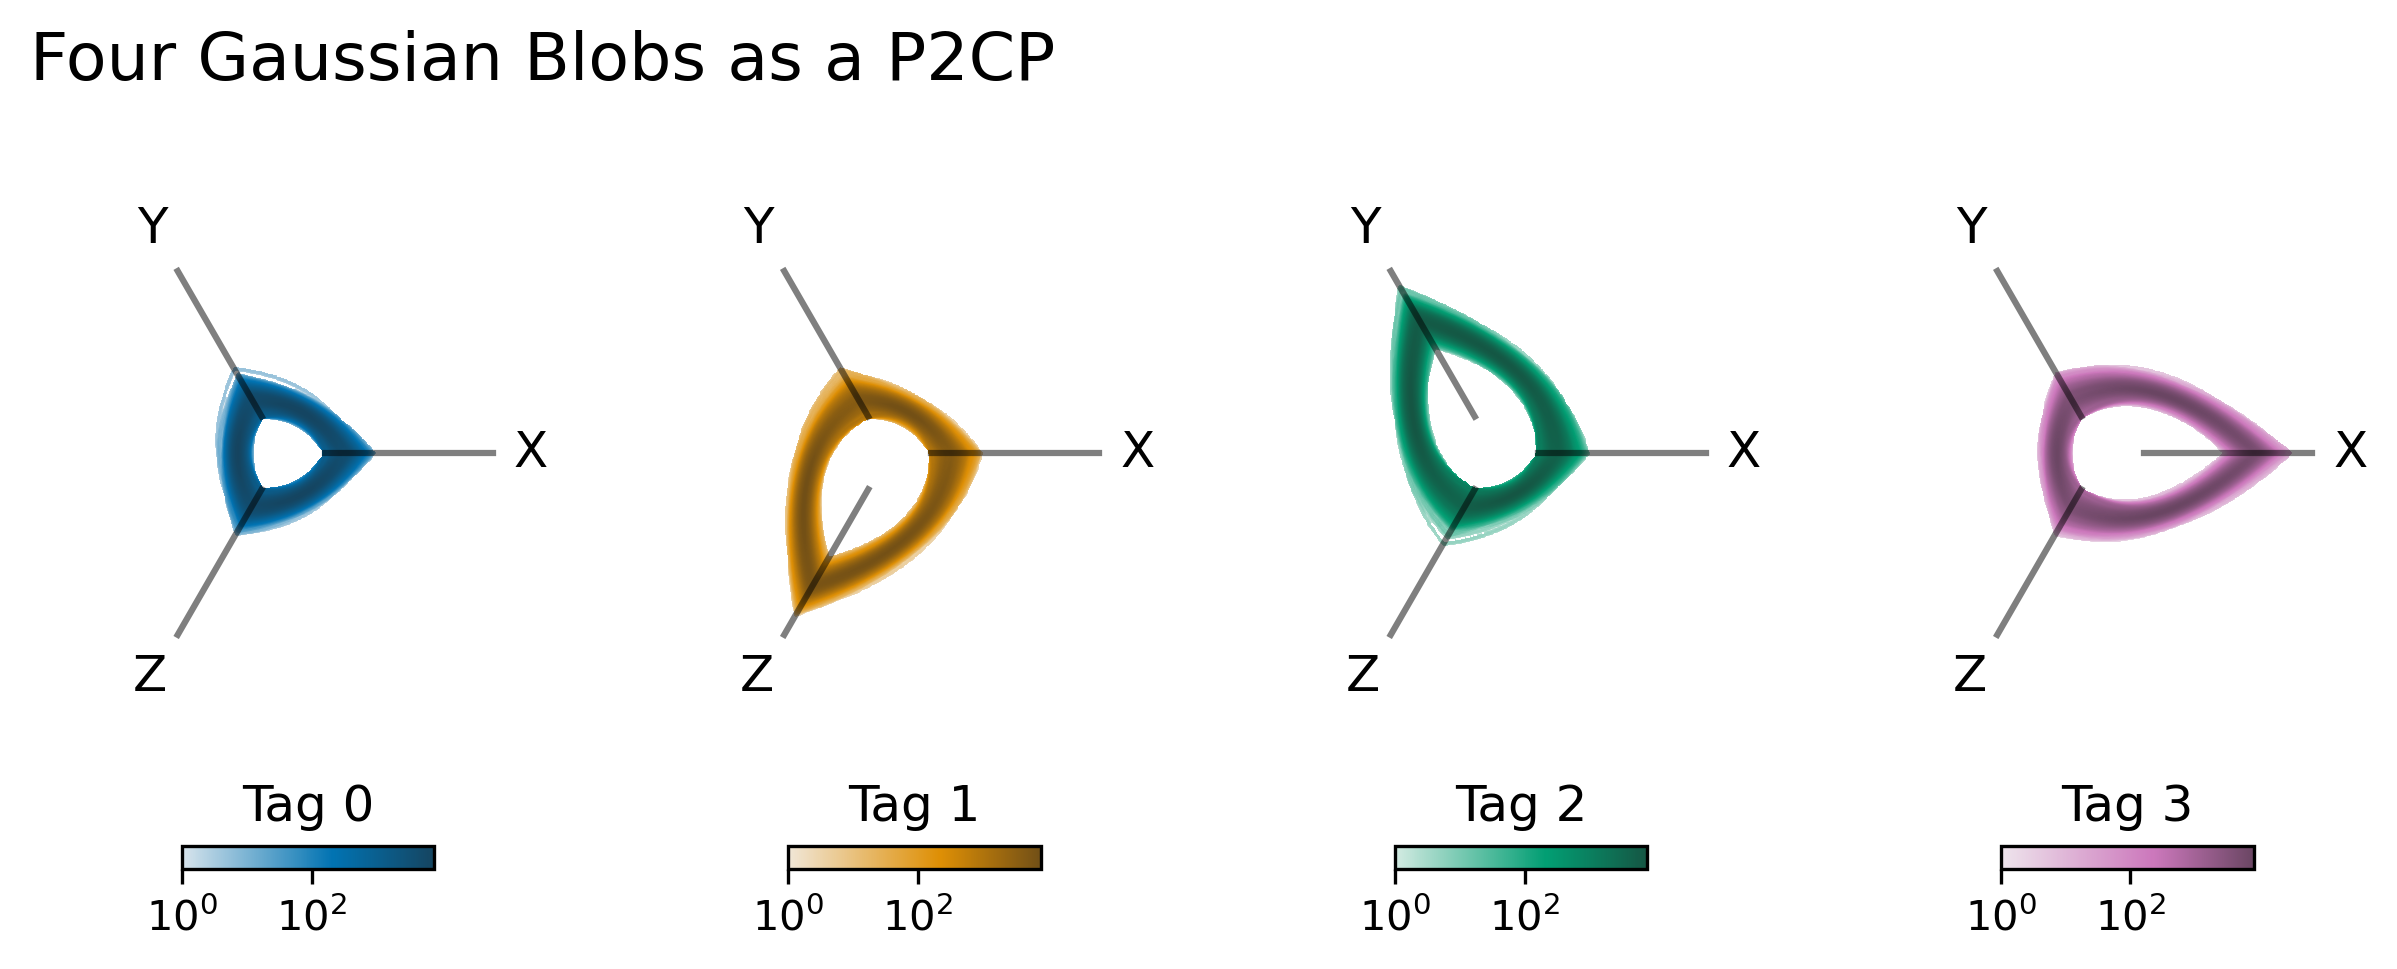

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2), dpi=300)

for i, tag in enumerate(p2cp.tags):
    # the (0, 0, 0) blob gets plotted first by default
    #  ends up being obscured by other edges unless
    #  we bring its lines to the front by changing zorder
    axes_viz(p2cp, fig=fig, ax=axes.flatten()[i], axes_labels_fontsize=12)
    _, _, temp_im = datashade_edges_mpl(
        p2cp, tag=tag, cmap=cmaps[tag], fig=fig, ax=axes.flatten()[i]
    )
    cax = axes.flatten()[i].inset_axes(
        [0.3, -0.4, 0.5, 0.05], transform=axes.flatten()[i].transAxes
    )
    cb = fig.colorbar(temp_im, cax=cax, shrink=0.2, orientation="horizontal")
    cb.ax.set_title(f"Tag {tag}")

fig.suptitle("Four Gaussian Blobs as a P2CP", size=16, y=1.2, ha="left", x=0.125)
plt.show()

As expected, datashading shows us our normally-distributed edges. In other words, each colored loop of edges is more densely represented in the middle than on the outer fringes.

Once we know what each of our tags of data looks like on its own, we can then create a multi-tag figure with a reference for whether we are obstructing data.

When shown side-by-side with the small multiples figure, the multi-tag figure allows us to better compare the inter-tag behavior while still offering a reference to what may be hidden by overlapping groups. 

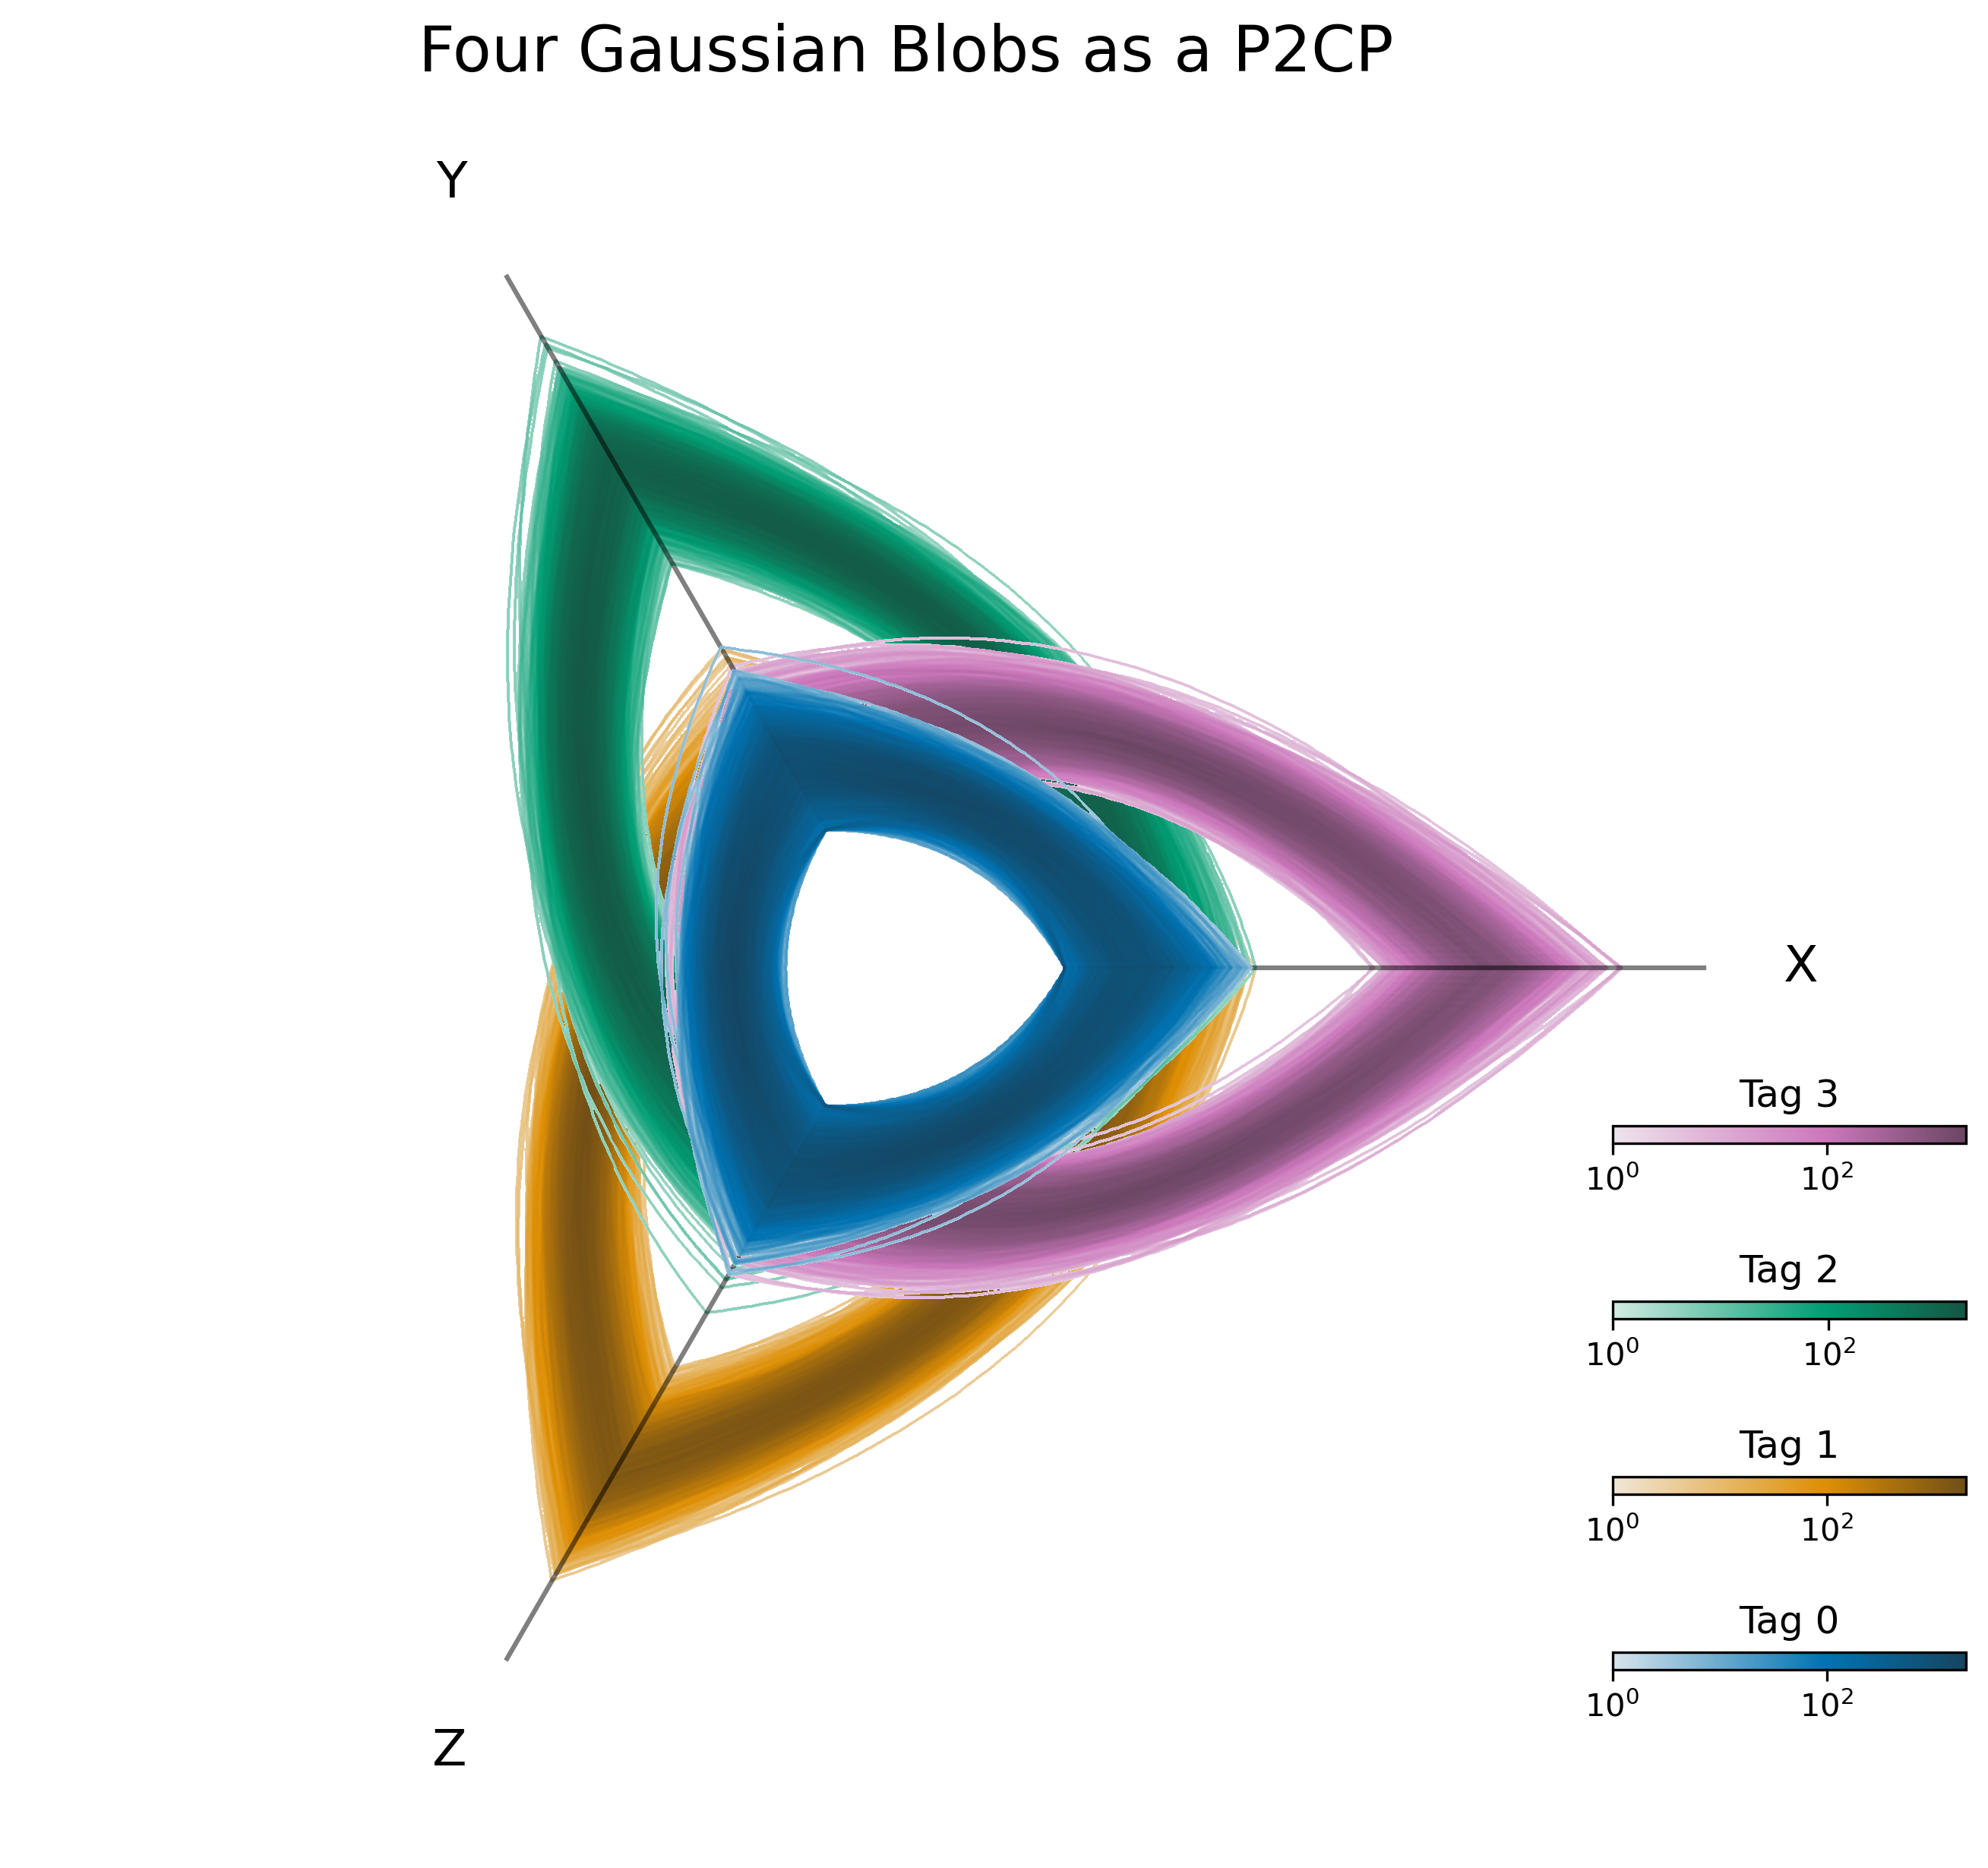

In [10]:
fig, ax = axes_viz(p2cp, figsize=(10, 10), fig_kwargs={"dpi": 300})

for i, tag in enumerate(p2cp.tags):
    # the (0, 0, 0) blob gets plotted first by default
    #  ends up being obscured by other edges unless
    #  we bring its lines to the front by changing zorder
    #  (which we would have discovered having looked at our small multiples figure first)
    extra_kwargs = {"zorder": 3} if tag == 0 else {}
    _, _, temp_im = datashade_edges_mpl(
        p2cp, tag=tag, cmap=cmaps[tag], fig=fig, ax=ax, **extra_kwargs
    )
    cax = ax.inset_axes([0.9, 0.1 + 0.1 * i, 0.2, 0.01], transform=ax.transAxes)
    cb = fig.colorbar(temp_im, cax=cax, shrink=0.2, orientation="horizontal")
    cb.ax.set_title(f"Tag {tag}")

ax.set_title("Four Gaussian Blobs as a P2CP", size=20)
plt.show()

#### References

Koplik, Gary, and Ashlee Valente. "The Parallel Coordinates Plot Revisited: Visual Extensions from Hive Plots, Heterogeneous Correlations, and an Exploration of Covid-19 Data in the United States." arXiv preprint arXiv:2109.10193 (2021).